In [3]:
import subprocess
from multiprocessing import Pool,cpu_count
import os
from itertools import product,repeat
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import spline
from scipy.ndimage.filters import gaussian_filter1d
from scipy import stats
import fileinput as fi
import seaborn as sns
from peaks import *
from sklearn.decomposition import PCA

%run averaging.ipynb
%run optimize_slope.ipynb

ncores=cpu_count()

ERROR:root:File `'averaging.ipynb.py'` not found.
ERROR:root:File `'optimize_slope.ipynb.py'` not found.


In [4]:
area_er = 2*(3.9+0.1+0.1*0.1+3.9*0.1)
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

# Initial RSnostim equilibrium check

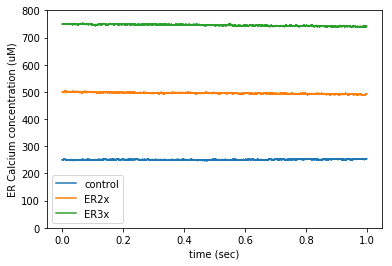

In [3]:
sims=["R150control","R150ER2x","R150ER3x","R300ER2x","R300ER3x"]
data_loc="/data/kabir/output/ppf/"
sim_type="RSnostim"

data_type=["ca.dat","pmca&leak_ca_flux.dat","serca_ca_flux.dat"]

plt.figure(figsize=(6,4))
for s in sims[0:3]:
    data_folder=data_loc+s+'/'+sim_type
    data_file=data_folder+"/s_00001/dat/"+data_type[0]
    ca_dat=np.loadtxt(data_file)
    #print(ca_dat)
    ydata=ca_dat.T[3]*1e15/N_avo/vol_er*1e6
    #ydata=ca_dat.T[2]-ca_dat.T[1]
    xdata=ca_dat.T[0]
    plt.plot(xdata,ydata,label=s.replace('R150',''))
plt.legend()
plt.xlabel("time (sec)")
plt.ylabel("ER Calcium concentration (uM)")

plt.ylim((0,800))
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/equilibrium.eps")

# Search and Replace in files

In [67]:
dataloc="/home/kabir/Project/tripartiteSynapse/mcell/R300ER2x/"
files=os.listdir(dataloc)
RSI_files=[]
for f in files:
    if "RSI" in f:
        RSI_files.append(f)
#RSI_files

In [68]:
for fn in RSI_files:
    with fi.FileInput(dataloc+fn,inplace=True, backup='.bak') as f:
        for line in f:
            print(line.replace('"ppf/"','"ppf/R300ER2x/"'), end='')

# kleak conversion to mcell

In [69]:
#from S Bandara et al 2013
J=0.07*250 #uM/s
J/=1e15/N_avo/vol_er*1e6
print("Ca Flux in ions/sec = ",J)

p=[2.1675959461586873, 6.214988757731395]
kleak=(J-p[1])/p[0]
print("Predicted kleak = ",kleak)

Ca Flux in ions/sec =  411.01111642500007
Predicted kleak =  186.74888573427603


# creating run.sh file

In [53]:
def seed_num(fname):
    vdcc_num=int(fname.split('V')[1].replace('.mdl',''))
    if vdcc_num>=110 and vdcc_num<=160:
        return 1000
    elif vdcc_num>=90 and vdcc_num<=100:
        return 2000
    elif vdcc_num>=70 and vdcc_num<=80:
        return 3000
    elif vdcc_num>=40 and vdcc_num<=60:
        return 5000
    else:
        return 10

In [151]:
a="""for name in fnames:
    input_loc=script_folder+'/'+name.replace('V90','V80')
    output_loc=script_folder+'/'+name
    with open(input_loc,'r') as infile:
        lines=infile.readlines()
    
    lines=[line.replace("VDCC_number_presynaptic = 80","VDCC_number_presynaptic = 90") for line in lines]
        
    with open(output_loc,'w') as outfile:
        outfile.writelines(lines)
#"""            

In [3]:
#ISI range

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[0]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=list(range(20,101,20))
VDCC=[90]
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
#fnames=["RSI20V90.mdl","RSI30V90.mdl","RSI40V90.mdl"]
print(fnames)
#seed_num=1000

/home/kabir/Project/tripartiteSynapse/mcell/R150control
isi = [20, 40, 60, 80, 100] 
vdcc = [90]
['RSI20V90.mdl', 'RSI40V90.mdl', 'RSI60V90.mdl', 'RSI80V90.mdl', 'RSI100V90.mdl']


In [378]:
#VDCC range

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[2]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=[20]
VDCC=list(range(60,101,20))
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
print(fnames)

/home/kabir/Project/tripartiteSynapse/mcell/R300ER2x
isi = [20] 
vdcc = [60, 80, 100]
['RSI20V60.mdl', 'RSI20V80.mdl', 'RSI20V100.mdl']


In [4]:
#3003x

sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
sim_type=sims[4]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"+'/'+sim_type
print(script_folder)
isi=[20]
VDCC=[70]
print('isi = '+str(isi),'\nvdcc = '+str(list(VDCC)))
fnames=[]
for (i,v) in product(isi,VDCC):
    fnames.append("RSI"+str(i)+"V"+str(v)+".mdl")
print(fnames)

/home/kabir/Project/tripartiteSynapse/mcell/R300ER3x
isi = [20] 
vdcc = [70]
['RSI20V70.mdl']


In [371]:
sims=["R150control","R150ER2x","R300ER2x","R150ER3x","R300ER3x"]
script_folder="/home/kabir/Project/tripartiteSynapse/mcell"
fnames=[s+'/RS20p20hz.mdl' for s in sims]
print(fnames)

['R150control/RS20p20hz.mdl', 'R150ER2x/RS20p20hz.mdl', 'R300ER2x/RS20p20hz.mdl', 'R150ER3x/RS20p20hz.mdl', 'R300ER3x/RS20p20hz.mdl']


In [373]:
#write run.sh
with open(script_folder+'/freq.sh','w') as f:
    for name in fnames:
            loc=script_folder+'/'+name
            f.write("sed --i 's/^#PBS -J.*/#PBS -J 1-"+str(1000)+"/' pbs.py\n")
            f.write("qsub -N "+name.replace("RS20p20hz.mdl",'').replace(script_folder,'')+" -v I='"+loc.replace('/kabir/Project/','/subhadra/kabir/')+"' pbs.py\n")
            f.write("\n")

In [ ]:
#write run.sh
with open(script_folder+'/run.sh','w') as f:
    for name in fnames:
            loc=script_folder+'/'+name
            f.write("sed --i 's/^#PBS -J.*/#PBS -J 1-"+str(seed_num(name))+"/' pbs.py\n")
            f.write("qsub -N "+name.replace(".mdl",sim_type).replace("RSI",'I')+" -v I='"+loc.replace('/kabir/Project/','/subhadra/kabir/')+"' pbs.py\n")
            f.write("\n")

#sync script files to cluster
p=subprocess.call(["rsync","-arhP",script_folder,"subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/mcell/"])

In [376]:
#sync script files to cluster
for s in sims:
    p=subprocess.call(["rsync","-arhP",script_folder+'/'+s,"subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/mcell/"])

In [280]:
outfolder='AD/RSI40V90'

In [41]:
outfolder='AD'#RSI40V90'

In [42]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/"+outfolder,"/data/kabir/output/ppf/"])

In [156]:
outfolder='R150control'#RSI40V90'

In [157]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/"+outfolder,"/data/kabir/output/ppf/"])

In [20]:
def all_analysis(name):
    print(name)
    dataDirName = name.replace(".mdl","")
    dataType = "freq/"
    
    M=analysis(dataDirName,dataType)
    
    data_files=['ca.dat', 'ryr_mol.dat', 'serca_ca_flux.dat', 'vdcc_pq_ca_flux.dat', 'calbindin_mol.dat',\
           'serca_mol.dat', 'pmca&leak_ca_flux.dat', 'rrp.dat', 'ryr_ca_flux.dat','az.dat']
    
    for data_file in data_files[-1:]:
        M.avg_dat(inFile="/dat/"+data_file, outFile="/"+data_file)
    #M.conc_calc(inFile="/ca.dat", outFile="/CaConc")

    #isi = int(M.dataDirName.split("I")[1].split("V")[0])
    #vdcc = int(M.dataDirName.split("V")[1])
    #print('isi: ', isi, '\nvdcc: ', vdcc)

    #M.relptp(20, resample=1000)

    #M.caStat_ptp(showFig=False)

In [21]:
%run analysis.ipynb
p=Pool(ncores)
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
#print(fnames)
p.starmap(all_analysis,product(fnames))
#all_analysis(fnames[-1])
#all_analysis("RSI20V90","R150ER2x")

R150ER2x20hz
R150control20hz

Calculating Average of
Calculating Average of /dat/az.dat
 /dat/az.dat
R150ER2x20hz
R150control20hz
seeds:  996
R150ER3x20hz

Calculating Average of /dat/az.dat
R150ER3x20hz
R300ER3x20hz

Calculating Average of /dat/az.dat
R300ER2x20hz
R300ER3x20hz

Calculating Average of /dat/az.dat
R300ER2x20hz
seeds:  996
seeds:  1000
seeds:  1000
seeds:  1000
185 s_00186 98000 [0.97999 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.     ]
186 s_00187 100001 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
401 s_00402 38000 [0.37999 0.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.      0.      0.
 0.     ]
402 s_00403 100001 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
485 s_00486 50000 [0.49999 1.      0.      0.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.      0.

[None, None, None, None, None]

Process ForkPoolWorker-4:
Process ForkPoolWorker-7:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Process ForkPoolWorker-5:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-3:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _boots

In [14]:
def all_analysis(name,data_file):
    print(name,data_file)
    dataDirName = name.replace(".mdl","")
    dataType = "freq/"
    
    M=analysis(dataDirName,dataType)
    
    M.avg_dat(inFile="/dat/"+data_file, outFile="/"+data_file)
    #M.conc_calc(inFile="/ca.dat", outFile="/CaConc")

    #isi = int(M.dataDirName.split("I")[1].split("V")[0])
    #vdcc = int(M.dataDirName.split("V")[1])
    #print('isi: ', isi, '\nvdcc: ', vdcc)

    #M.relppf(isi, vdcc, resample=1000)

    #M.caStat(showFig=True)

In [15]:
%run analysis.ipynb
p=Pool(ncores-1)
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
print(fnames)
data_files=['ca.dat', 'ryr_mol.dat', 'serca_ca_flux.dat', 'vdcc_pq_ca_flux.dat', 'calbindin_mol.dat',\
            'serca_mol.dat', 'pmca&leak_ca_flux.dat', 'rrp.dat', 'ryr_ca_flux.dat']
p.starmap(all_analysis,product(fnames,data_files[1:]))
#all_analysis(fnames[-1])
#all_analysis("RSI20V90","R150ER2x")

R150control20hz rrp.dat
R150control20hz ryr_mol.dat
R150control20hz serca_mol.dat
R150ER2x20hz serca_mol.dat
R150control20hz vdcc_pq_ca_flux.dat
R150ER2x20hz vdcc_pq_ca_flux.dat

Calculating Average of
Calculating Average of
Calculating Average of
Calculating Average of
Calculating Average ofR150ER2x20hz ryr_mol.dat
 /dat/serca_mol.dat

Calculating Average of /dat/rrp.dat
 /dat/serca_mol.dat
 /dat/vdcc_pq_ca_flux.dat
 /dat/ryr_mol.dat
R150control20hz

Calculating Average ofR150ER2x20hz
R150control20hz
 /dat/vdcc_pq_ca_flux.dat
R150control20hz
R150control20hz
seeds:  996
 /dat/ryr_mol.dat
seeds:  996
seeds:  996
seeds:  996
R150ER2x20hz
seeds:  996
R150ER2x20hz
seeds:  996
seeds:  996
['R150control20hz', 'R150ER2x20hz', 'R300ER2x20hz', 'R150ER3x20hz', 'R300ER3x20hz']
Writing average to: /home/kabir/Project/tripartiteSynapse/results/freq/R150ER2x20hz/vdcc_pq_ca_flux.dat
R150ER2x20hz calbindin_mol.dat

Calculating Average of /dat/calbindin_mol.dat
R150ER2x20hz
seeds:  996
Writing average 

186 s_00187 100001 [1.0000e+00 7.6651e+04 8.0530e+03 1.1800e+02]
Writing average to: /home/kabir/Project/tripartiteSynapse/results/freq/R300ER2x20hz/ryr_ca_flux.dat
R150ER3x20hz rrp.dat

Calculating Average of /dat/rrp.dat
R150ER3x20hz
seeds:  1000
664 s_00665 85000 [8.4999e-01 1.3200e+02 4.6200e+02 5.1900e+02 9.0300e+02 3.9120e+03
 3.8660e+03 1.7810e+03 7.1310e+03 7.3640e+03]
665 s_00666 100001 [1.000e+00 5.200e+01 2.820e+02 4.130e+02 5.440e+02 2.944e+03 3.783e+03
 1.420e+03 7.267e+03 9.413e+03]
401 s_00402 38000 [0.37999 0.     ]
402 s_00403 100001 [1. 0.]
712 s_00713 99000 [9.8999e-01 3.2000e+01 2.3700e+02 3.2900e+02 4.0700e+02 2.4380e+03
 3.7980e+03 1.0940e+03 7.0960e+03 1.0655e+04]
713 s_00714 100001 [1.0000e+00 4.8000e+01 2.5000e+02 3.4300e+02 4.2500e+02 2.6710e+03
 3.7130e+03 1.2640e+03 7.1930e+03 1.0135e+04]
Writing average to: /home/kabir/Project/tripartiteSynapse/results/freq/R150ER3x20hz/serca_mol.dat
R150ER3x20hz pmca&leak_ca_flux.dat

Calculating Average of /dat/pmca&leak_

 3.6110e+03 1.1640e+03 7.0650e+03 1.0677e+04]
Writing average to: /home/kabir/Project/tripartiteSynapse/results/freq/R300ER3x20hz/ryr_ca_flux.dat
Writing average to: /home/kabir/Project/tripartiteSynapse/results/freq/R300ER3x20hz/calbindin_mol.dat
485 s_00486 50000 [  0.49999  10.      497.     ]
486 s_00487 100001 [1.000e+00 2.200e+01 1.076e+03]
485 s_00486 50000 [4.9999e-01 3.3087e+04 4.8080e+03 2.6000e+01]
486 s_00487 100001 [1.0000e+00 8.1989e+04 7.3630e+03 7.0000e+01]
670 s_00671 30000 [  0.29999  13.      275.     ]
671 s_00672 100001 [1.000e+00 2.200e+01 1.114e+03]
670 s_00671 30000 [2.9999e-01 1.6791e+04 3.2710e+03 4.7000e+01]
671 s_00672 100001 [1.000e+00 8.335e+04 7.183e+03 4.600e+01]
887 s_00888 45000 [  0.44999   6.      406.     ]
888 s_00889 100001 [1.000e+00 1.000e+01 1.083e+03]
Writing average to: /home/kabir/Project/tripartiteSynapse/results/freq/R300ER3x20hz/serca_ca_flux.dat
887 s_00888 45000 [4.4999e-01 2.8657e+04 4.5050e+03 4.3000e+01]
888 s_00889 100001 [1.000e+00

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

/home/kabir/Project/tripartiteSynapse/results/freq/R150control20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R150ER2x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R300ER2x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R150ER3x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R300ER3x20hz/result


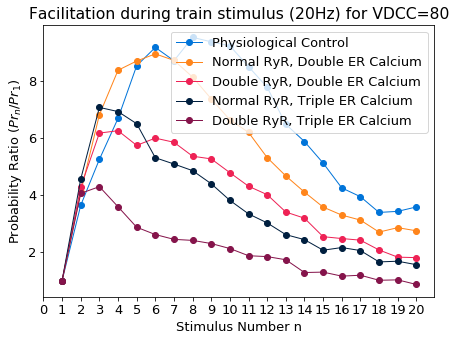

In [42]:
plt.rc('font',size=13)

color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

better_sim_names = {
    #"ryr_old":"old model",
    "stores_blocked":"stores blocked",
    "R150control20hz":"Physiological Control", 
    "R150ER2x20hz":"Normal RyR, Double ER Calcium",
    "R150ER3x20hz":"Normal RyR, Triple ER Calcium",
    "R300ER3x20hz":"Double RyR, Triple ER Calcium",
    "R300ER2x20hz":"Double RyR, Double ER Calcium"
    
}


res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"] # 
for sim_type in fnames:
    loc=res_loc+sim_type+"/result"
    print(loc)
    data[sim_type]=np.loadtxt(loc)
    
    
plt.figure(figsize=(7,5))
plt.tight_layout()
for i,sim_type in enumerate(fnames):
    xdata=data[sim_type].T[0]
    ydata=data[sim_type].T[3]
    plt.plot(xdata,ydata,'-o',color=color[i],label=better_sim_names[sim_type],lw="1")



    
plt.xticks(range(21))
plt.xlabel("Stimulus Number n")
plt.ylabel("Probability Ratio ($Pr_{n}/Pr_{1}$)")

plt.title("Facilitation during train stimulus (20Hz) for VDCC=80")

plt.legend()

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/train20hz.eps",transparent=True)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/jpeg/train20hz.jpeg",dpi=300)

/home/kabir/Project/tripartiteSynapse/results/freq/R150control20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R150ER2x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R300ER2x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R150ER3x20hz/result
/home/kabir/Project/tripartiteSynapse/results/freq/R300ER3x20hz/result


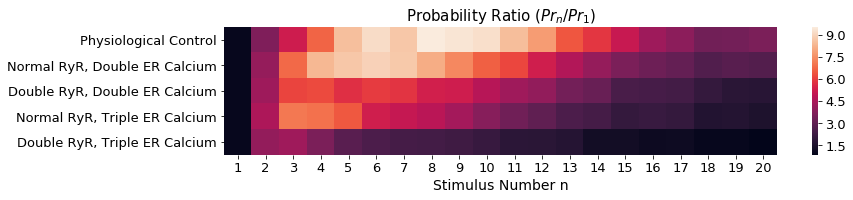

In [225]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"] # 
for sim_type in fnames:
    loc=res_loc+sim_type+"/result"
    print(loc)
    data[sim_type]=np.loadtxt(loc)

fig,ax=plt.subplots(ncols=1,figsize=(14,3),sharex=True)


data_Pr=[data[sim_type].T[3] for sim_type in fnames]

sns.heatmap(data_Pr,xticklabels=range(1,21),yticklabels=[better_sim_names[name] for name in fnames],ax=ax)
ax.set_title("Probability Ratio ($Pr_{n}/Pr_{1}$)",fontsize=15)

ax.set_xlabel("Stimulus Number n",fontsize=14)
plt.tight_layout()
plt.subplots_adjust(left=0.3,bottom=0.25)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/train_pratio_heat.eps")

In [8]:
for sim_type in fnames:
    print(better_sim_names[sim_type],data[sim_type].T[1][0])

Physiological Control 0.0744
Normal RyR, Double ER Calcium 0.0872
Double RyR, Double ER Calcium 0.1187
Normal RyR, Triple ER Calcium 0.1308
Double RyR, Triple ER Calcium 0.2304


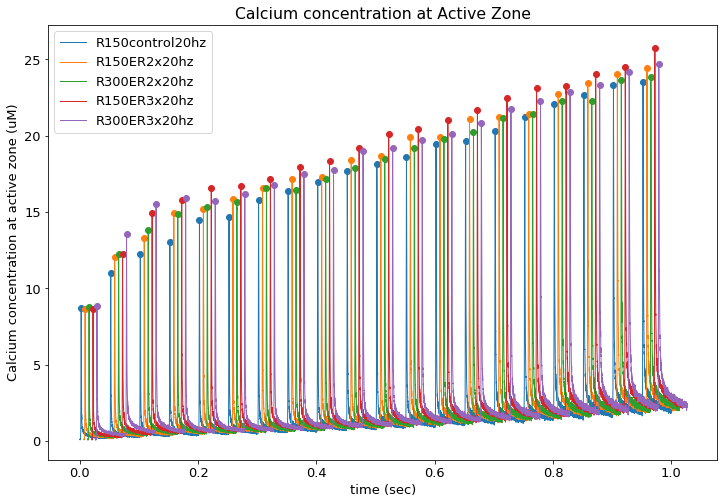

In [237]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]

for name in fnames:
    #name="R150ER2x20hz"
    loc=res_loc+'/'+name.replace(".mdl","")+'/'+'CaConc'
    data[name]=np.loadtxt(loc)
    
plt.figure(figsize=(12,8))

for i,name in enumerate(fnames):
    xdata=data[name].T[0]+i/150
    ydata=data[name].T[1] #gaussian_filter1d(data[name].T[1],sigma=10)
    plt.plot(xdata,ydata,label=name,lw='1')
    p=detect_peaks(ydata,mpd=500,mph=8)
    plt.scatter(xdata[p],ydata[p])

spikes=xdata[detect_peaks(ydata,mpd=500,mph=8)]
    
plt.xlabel("time (sec)")
plt.ylabel("Calcium concentration at active zone (uM)")
plt.title("Calcium concentration at Active Zone")

#plt.ylim((8,10))
#plt.xlim((0.00,0.005))

#plt.ylim((8,14))
#plt.xlim((0.05,0.055))

#plt.ylim((12,16))
#plt.xlim((0.1,0.105))

plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/aztrain20hz.eps")

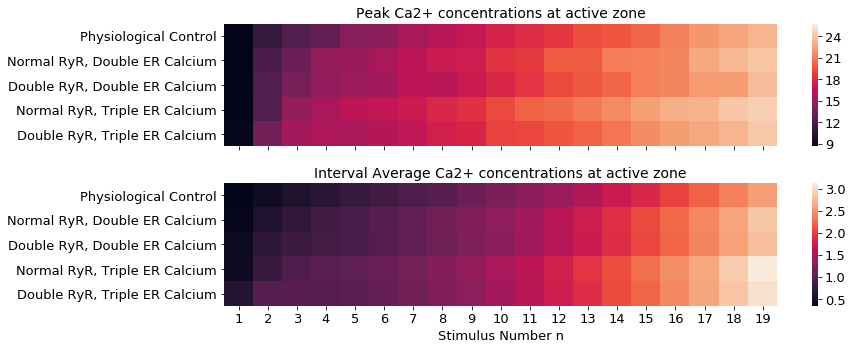

In [229]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]

for name in fnames:
    #name="R150ER2x20hz"
    loc=res_loc+'/'+name.replace(".mdl","")+'/'+'CaConc'
    data[name]=np.loadtxt(loc)
    
fig,ax=plt.subplots(2,1,figsize=(14,5),sharex=True)

for i,name in enumerate(fnames):
    xdata=data[name].T[0]#+i/150
    ydata=data[name].T[1] #gaussian_filter1d(data[name].T[1],sigma=10)
    #plt.plot(xdata,ydata,label=name,lw='1')
    p=detect_peaks(ydata,mpd=500,mph=8)
    #plt.scatter(xdata[p],ydata[p])

data_peaks=[data[name].T[1][detect_peaks(data[name].T[1],mpd=500,mph=8)] for name in fnames]
data_bins=[[np.average(data[name].T[1][detect_peaks(data[name].T[1],mpd=500,mph=8)[i]+10:\
                                       detect_peaks(data[name].T[1],mpd=500,mph=8)[i+1]-10],axis=0) for i in range(19)] for name in fnames]

sns.heatmap(data_peaks,xticklabels=range(1,21),yticklabels=[better_sim_names[name] for name in fnames],ax=ax[0])
sns.heatmap(data_bins,xticklabels=range(1,20),yticklabels=[better_sim_names[name] for name in fnames],ax=ax[1])  

#plt.ylim((8,10))
#plt.xlim((0.00,0.005))

#plt.ylim((8,14))
#plt.xlim((0.05,0.055))

#plt.ylim((12,16))
#plt.xlim((0.1,0.105))

ax[0].set_title("Peak Ca2+ concentrations at active zone",fontsize=14)
ax[1].set_title("Interval Average Ca2+ concentrations at active zone",fontsize=14)

ax[-1].set_xlabel("Stimulus Number n")
plt.tight_layout()
plt.subplots_adjust(left=0.3,bottom=0.13)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/az_calcium_train_heat.eps")

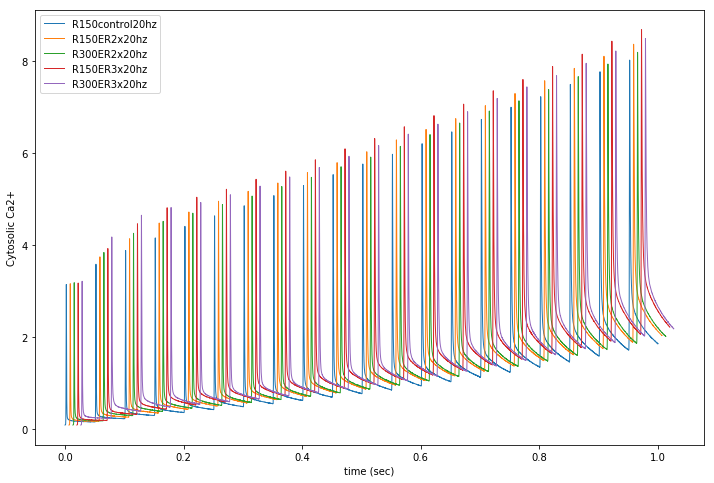

In [14]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
for name in fnames:
    data[name]={}
    loc=res_loc+name.replace(".mdl","")+'/'+'ca.dat'
    data[name]=np.loadtxt(loc)
    

plt.figure(figsize=(12,8))
for i,name in enumerate(fnames):
    xdata=data[name].T[0]+i/150
    ydata=data[name].T[2]/602.3
    plt.plot(xdata,ydata,label=name,lw="1")

    
#plt.xlim((0,0.1))
#plt.ylim((0,1))
plt.xlabel("time (sec)")
plt.ylabel("Cytosolic Ca2+")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ryr_fluxRSI20V80.eps")

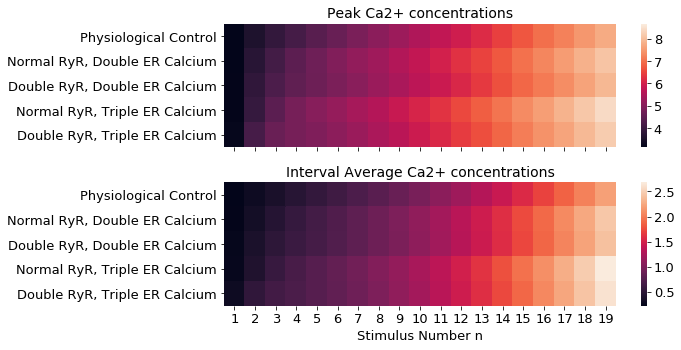

In [43]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
for name in fnames:
    data[name]={}
    loc=res_loc+name.replace(".mdl","")+'/'+'ca.dat'
    data[name]=np.loadtxt(loc)
    
fig,ax=plt.subplots(2,1,figsize=(10,5),sharex=True)

p=detect_peaks(data["R150control20hz"].T[2]/602.3,mpd=3000,mph=3)
    
data_peaks=[data[name].T[2][detect_peaks(data[name].T[2]/602.3,mpd=3000,mph=3)]/602.3 for name in fnames]
data_bins=[[np.average(data[name].T[2][detect_peaks(data[name].T[2]/602.3,mpd=3000,mph=3)[i]+10:\
                                       detect_peaks(data[name].T[2]/602.3,mpd=3000,mph=3)[i+1]-10],axis=0)/602.3 for i in range(19)] for name in fnames]
           

np.set_printoptions(precision=4)
sns.heatmap(data_peaks,xticklabels=range(1,21),yticklabels=[better_sim_names[name] for name in fnames],ax=ax[0])
sns.heatmap(data_bins,xticklabels=range(1,20),yticklabels=[better_sim_names[name] for name in fnames],ax=ax[1])    
    


ax[0].set_title("Peak Ca2+ concentrations",fontsize=14)
ax[1].set_title("Interval Average Ca2+ concentrations",fontsize=14)
ax[-1].set_xlabel("Stimulus Number n")

plt.tight_layout()
plt.subplots_adjust(left=0.3,bottom=0.13)
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ryr_fluxRSI20V80.eps")

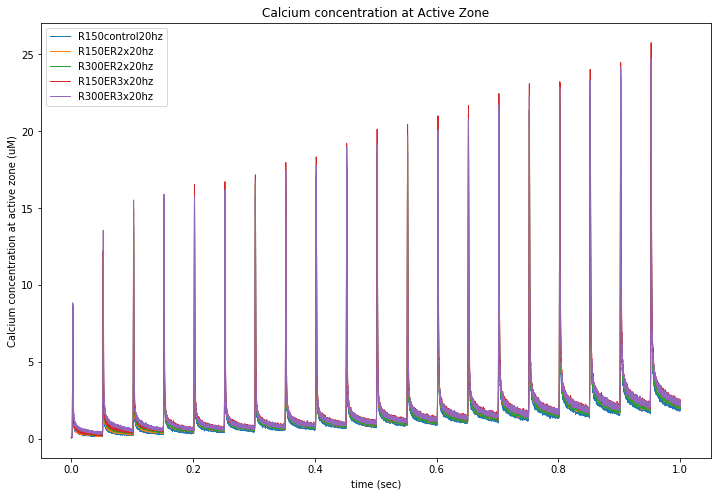

In [11]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]

for name in fnames:
    #name="R150ER2x20hz"
    loc=res_loc+'/'+name.replace(".mdl","")+'/'+'CaConc'
    data[name]=np.loadtxt(loc)
    
plt.figure(figsize=(12,8))

for i,name in enumerate(fnames):
    xdata=data[name].T[0]#+i/150
    ydata=data[name].T[1] #gaussian_filter1d(data[name].T[1],sigma=10)
    plt.plot(xdata,ydata,label=name,lw='1')

plt.xlabel("time (sec)")
plt.ylabel("Calcium concentration at active zone (uM)")
plt.title("Calcium concentration at Active Zone")

#plt.ylim((8,10))
#plt.xlim((0.00,0.005))

#plt.ylim((8,14))
#plt.xlim((0.05,0.055))

#plt.ylim((12,16))
#plt.xlim((0.1,0.105))

plt.legend()
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/aztrain20hz.eps")

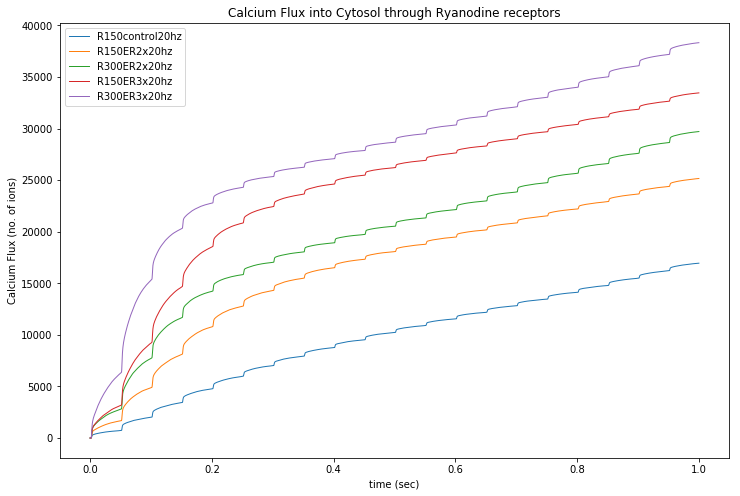

In [16]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
for name in fnames:
    data[name]={}
    loc=res_loc+name.replace(".mdl","")+'/'+'ryr_ca_flux.dat'
    data[name]=np.loadtxt(loc)
    

plt.figure(figsize=(12,8))
for name in fnames:
    xdata=data[name].T[0]
    ydata=data[name].T[1]
    plt.plot(xdata,ydata,label=name,lw="1")

plt.xlabel("time (sec)")
plt.ylabel("Calcium Flux (no. of ions)")
plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ryr_fluxRSI20V80.eps")

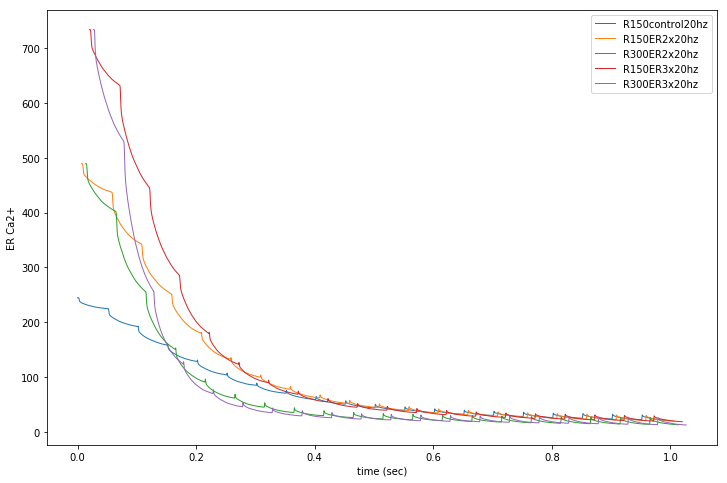

In [6]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
for name in fnames:
    data[name]={}
    loc=res_loc+name.replace(".mdl","")+'/'+'ca.dat'
    data[name]=np.loadtxt(loc)
    

plt.figure(figsize=(12,8))
for i,name in enumerate(fnames):
    xdata=data[name].T[0]+i/150
    ydata=data[name].T[3]/24#/602.3
    plt.plot(xdata,ydata,label=name,lw="1")

    
#plt.xlim((0,0.1))
#plt.ylim((0,1))
plt.xlabel("time (sec)")
plt.ylabel("ER Ca2+")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ryr_fluxRSI20V80.eps")

In [46]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
data={}
synchro={}
asynchro={}
for name in fnames:
    loc=res_loc+name.replace(".mdl","")+'/'+'az.dat'
    data[name]=np.loadtxt(loc)
    #data[name].shape
    #synchro[name]=data[name].T[6]+data[name].T[12]+data[name].T[18]
    #asynchro[name]=np.sum(data[name].T[13:19],axis=0)

pca = PCA(n_components=18)
pca.fit(data["R150control20hz"][p,1:])
PCs={}
for name in fnames:
    PCs[name]=pca.transform(data[name][p,1:])

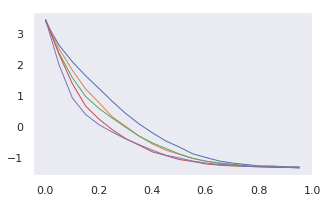

In [84]:
f, ax = plt.subplots(nrows=1, sharex=True, figsize=(5,3))
f.subplots_adjust(hspace=0.4)
sns.set_style("dark")
for i,name in enumerate(fnames):
    #ax[i]=
    ax=sns.lineplot(data["R150control20hz"][p,0],PCs[name].T[0],linewidth=1)#data["R150control20hz"][p,0]


Text(0.5, 0, 'time (sec)')

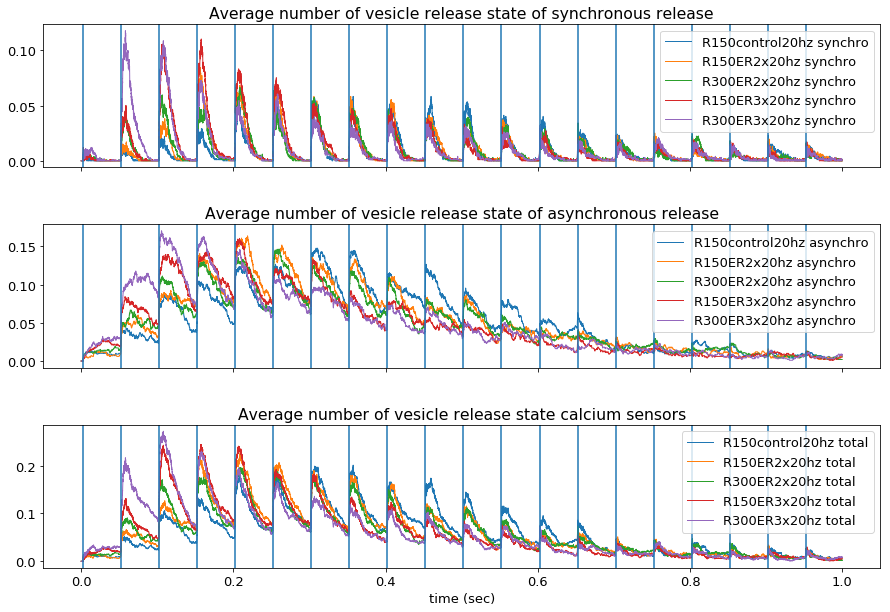

In [99]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
data={}
synchro={}
asynchro={}
for name in fnames:
    loc=res_loc+name.replace(".mdl","")+'/'+'az.dat'
    data[name]=np.loadtxt(loc)
    synchro[name]=data[name].T[6]+data[name].T[12]+data[name].T[18]
    asynchro[name]=np.sum(data[name].T[13:19],axis=0)

f, ax = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
f.subplots_adjust(hspace=0.4)
for name in fnames:
    xdata=data[name].T[0]
    ax[0].plot(xdata,synchro[name],label=name+" synchro",lw="1")
    ax[1].plot(xdata,asynchro[name],label=name+" asynchro",lw="1")
    ax[2].plot(xdata,asynchro[name]+synchro[name],label=name+" total",lw="1")
for a in ax:
    for x in p:
        a.axvline(xdata[x*5])
    
titles=["Average number of vesicle release state of synchronous release",
        "Average number of vesicle release state of asynchronous release",
        "Average number of vesicle release state calcium sensors"]
for xis,title in zip(ax,titles):
    #xis.set_ylabel("PMCA outflux")
    xis.legend()
    xis.set_title(title)
    
ax[-1].set_xlabel("time (sec)")

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/releaseRSI20V80.eps")

Text(0.5, 21.0, 'Spike interval')

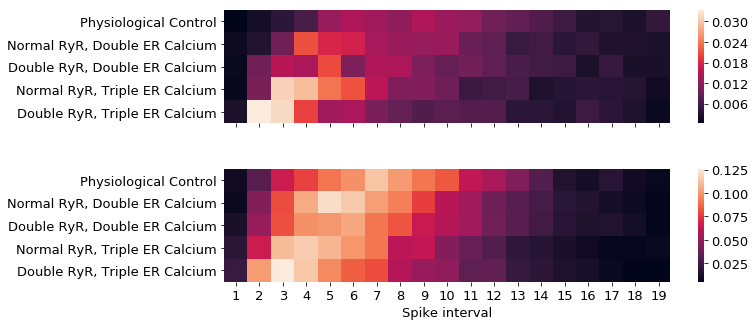

In [187]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
data={}
synchro={}
asynchro={}
for name in fnames:
    loc=res_loc+name.replace(".mdl","")+'/'+'az.dat'
    data[name]=np.loadtxt(loc)
    synchro[name]=data[name].T[6]+data[name].T[12]+data[name].T[18]
    asynchro[name]=np.sum(data[name].T[13:19],axis=0)

f, ax = plt.subplots(nrows=2, sharex=True, figsize=(10,5))
f.subplots_adjust(hspace=0.4)

titles=["Average number of vesicle release state of synchronous release",
        "Average number of vesicle release state of asynchronous release",
        "Average number of vesicle release state calcium sensors"]

synchro_data_bins=[[np.average(synchro[name][p[i]*5:p[i+1]*5-10],axis=0) for i in range(19)] for name in fnames]
asynchro_data_bins=[[np.average(asynchro[name][p[i]*5:p[i+1]*5-10],axis=0) for i in range(19)] for name in fnames]

sns.heatmap(synchro_data_bins,xticklabels=range(1,20),yticklabels=[better_sim_names[name] for name in fnames],ax=ax[0])
sns.heatmap(asynchro_data_bins,xticklabels=range(1,20),yticklabels=[better_sim_names[name] for name in fnames],ax=ax[1])

#for xis,title in zip(ax,titles):
#    #xis.set_ylabel("PMCA outflux")
#    xis.legend()
#    xis.set_title(title)
    
ax[-1].set_xlabel("Spike interval")

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/releaseRSI20V80.eps")

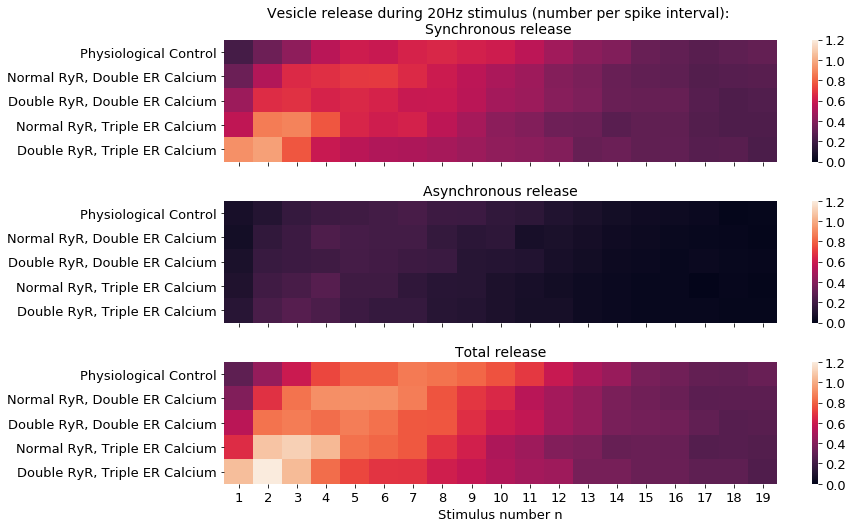

In [276]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
data={}
synchro={}
asynchro={}
total={}
for name in fnames:
    loc=res_loc+name.replace(".mdl","")+'/'+'syncRel'
    synchro[name]=np.array(np.genfromtxt(loc, dtype="|U5").T[0],dtype="float")
    loc=res_loc+name.replace(".mdl","")+'/'+'asyncRel'
    asynchro[name]=np.array(np.genfromtxt(loc, dtype="|U5").T[0],dtype="float")
    loc=res_loc+name.replace(".mdl","")+'/'+'vesRel'
    total[name]=np.array(np.genfromtxt(loc, dtype="|U5").T[0],dtype="float")

synchro_data_bin=[np.histogram(synchro[name],bins=spikes)[0]/1000 for name in fnames]
asynchro_data_bin=[np.histogram(asynchro[name],bins=spikes)[0]/1000 for name in fnames]
total_data_bin=[np.histogram(total[name],bins=spikes)[0]/1000 for name in fnames]

f, ax = plt.subplots(nrows=3, sharex=True, figsize=(14,7.5))

sns.heatmap(synchro_data_bin,vmin=0,vmax=1.2,xticklabels=range(1,20),yticklabels=[better_sim_names[name] for name in fnames],ax=ax[0])
sns.heatmap(asynchro_data_bin,vmin=0,vmax=1.2,xticklabels=range(1,20),yticklabels=[better_sim_names[name] for name in fnames],ax=ax[1])    
sns.heatmap(total_data_bin,vmin=0,vmax=1.2,xticklabels=range(1,20),yticklabels=[better_sim_names[name] for name in fnames],ax=ax[2])    



titles=["Vesicle release during 20Hz stimulus (number per spike interval): \nSynchronous release ",
        "Asynchronous release",
        "Total release"]
for t,a in zip(titles,ax):
    a.set_title(t,fontsize=14)
    
ax[-1].set_xlabel("Stimulus number n")

#plt.title("Vesicle Release")

plt.subplots_adjust(hspace=0.2)

plt.tight_layout()
plt.subplots_adjust(left=0.3,bottom=0.09)
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/20hztrain_release_heat.eps")

In [144]:
xdata

(array([ 75, 113, 170, 193, 199, 211, 229, 195, 191, 159, 143, 107,  86,
         62,  47,  45,  33,  12,  16]),
 array([0.0289, 0.079 , 0.1289, 0.1789, 0.2289, 0.2789, 0.3289, 0.3789,
        0.4289, 0.4789, 0.5289, 0.5789, 0.6289, 0.6789, 0.7289, 0.7789,
        0.8289, 0.8789, 0.9289, 0.9789]))

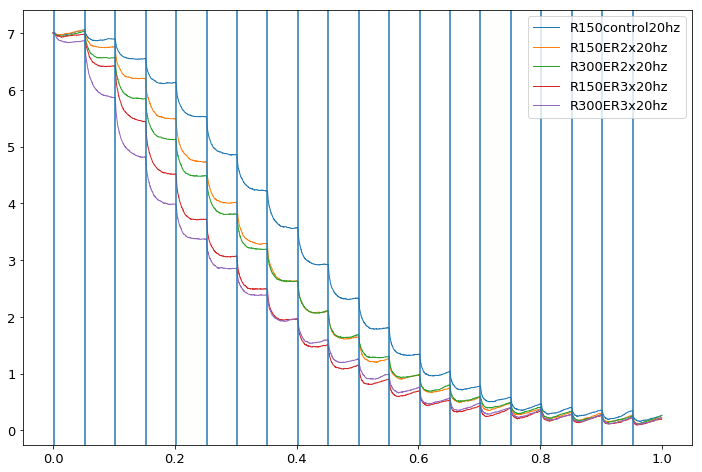

In [259]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
for name in fnames:
    data[name]={}
    loc=res_loc+name.replace(".mdl","")+'/'+'rrp.dat'
    data[name]=np.loadtxt(loc)
    

plt.figure(figsize=(12,8))
for name in fnames:
    xdata=data[name].T[0]
    ydata=data[name].T[1]
    plt.plot(xdata,ydata,label=name,lw="1")

for i in range(20):
    plt.axvline(xdata[p[i]*5])


plt.legend()
#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/ryr_fluxRSI20V80.eps")

In [257]:
p

array([   45,  1046,  2044,  3044,  4045,  5045,  6044,  7045,  8045,
        9044, 10044, 11044, 12045, 13044, 14045, 15044, 16044, 17044,
       18044, 19044])

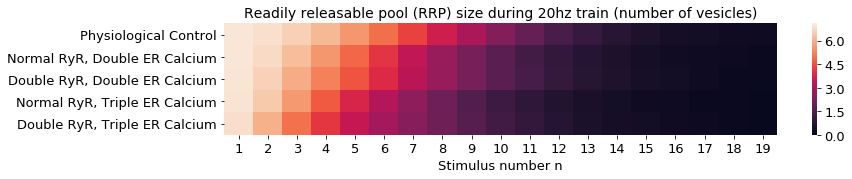

In [279]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data={}
fnames=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
for name in fnames:
    data[name]={}
    loc=res_loc+name.replace(".mdl","")+'/'+'rrp.dat'
    data[name]=np.loadtxt(loc)

RRP_bin={}

RRP_bin=[[np.average(data[name].T[1][p[i]*5+10:p[i+1]*5-10],axis=0) for i in range(19)] for name in fnames]

f, ax = plt.subplots(nrows=1, sharex=True, figsize=(14,2.5))

sns.heatmap(RRP_bin,vmin=0,vmax=7.1,xticklabels=range(1,20),yticklabels=[better_sim_names[name] for name in fnames],ax=ax)

ax.set_xlabel("Stimulus number n")

plt.tight_layout()
plt.subplots_adjust(left=0.3)#,bottom=0.25)
ax.set_title("Readily releasable pool (RRP) size during 20hz train (number of vesicles)",fontsize=14)
plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/train_RRP_heat.eps")

In [244]:
p

array([   45,  1046,  2044,  3044,  4045,  5045,  6044,  7045,  8045,
        9044, 10044, 11044, 12045, 13044, 14045, 15044, 16044, 17044,
       18044, 19044])

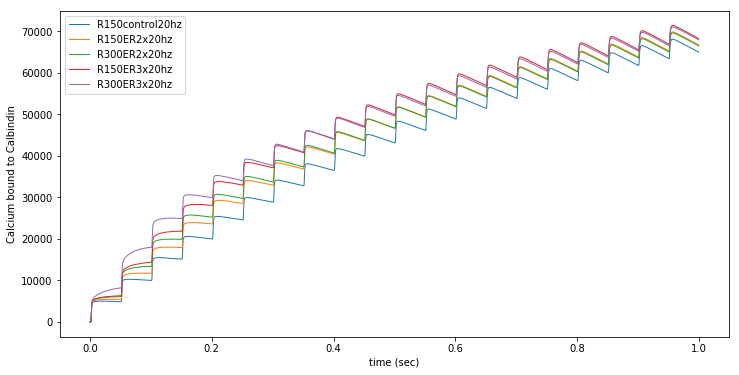

In [40]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data_bound={}
bnd_cal={}
sims=["R150control20hz","R150ER2x20hz","R300ER2x20hz","R150ER3x20hz","R300ER3x20hz"]
for sim_type in sims:
    loc1=res_loc+'/'+sim_type.replace(".mdl","")+'/'+'calbindin_mol.dat'
    loc2=res_loc+'/'+sim_type.replace(".mdl","")+'/'+'calB.dat'
    if os.path.isfile(loc1):
        data_bound[sim_type]=np.loadtxt(loc1)
    else:
        data_bound[sim_type]=np.loadtxt(loc2)
    bnd_cal[sim_type]=data_bound[sim_type].T[2]+data_bound[sim_type].T[4]+2*(data_bound[sim_type].T[3]+data_bound[sim_type].T[5]+data_bound[sim_type].T[7])+3*(data_bound[sim_type].T[6]+data_bound[sim_type].T[8])+4*data_bound[sim_type].T[9]
    bnd_cal[sim_type]=bnd_cal[sim_type]-bnd_cal[sim_type][0]

plt.figure(figsize=(12,6))
for sim_type in sims:
    xdata=data_bound[sim_type].T[0]
    ydata=bnd_cal[sim_type]
    plt.plot(xdata,ydata,label=sim_type,lw="1")
plt.xlabel("time (sec)")
plt.ylabel("Calcium bound to Calbindin")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend()

#plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/calb_boundRSI20V80.eps")

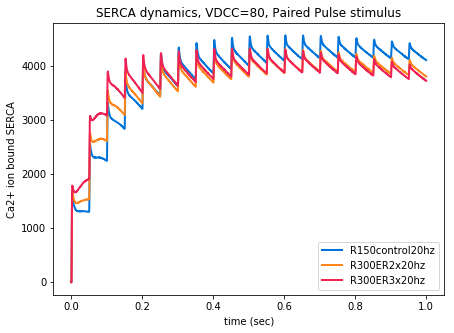

In [45]:
res_loc="/home/kabir/Project/tripartiteSynapse/results/freq/"
data_bound={}
bnd_cal={}
cpalette=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sims=["R150control20hz","R300ER2x20hz" ,"R300ER3x20hz"] #"ryr_old", ,"R150ER3x" ,"R150ER2x"
for sim_type in sims:
    #name="RSI20V80"
    loc1=res_loc+sim_type+'/'+'serca_mol.dat'
    loc2=res_loc+sim_type+'/'+'sercaMol.dat'
    if os.path.isfile(loc1):
        data_bound[sim_type]=np.loadtxt(loc1)
    else:
        data_bound[sim_type]=np.loadtxt(loc2)
    bnd_cal[sim_type]=data_bound[sim_type].T[4]*2+data_bound[sim_type].T[5]+data_bound[sim_type].T[2]+data_bound[sim_type].T[3]*2
    bnd_cal[sim_type]=bnd_cal[sim_type]-bnd_cal[sim_type][0]

plt.figure(figsize=(7,5))
for i,sim_type in enumerate(sims):
    xdata=data_bound[sim_type].T[0]
    ydata=bnd_cal[sim_type]
    plt.plot(xdata,ydata,label=sim_type,lw="2",color=cpalette[i])
plt.xlabel("time (sec)")
plt.ylabel("Ca2+ ion bound SERCA")
plt.title("SERCA dynamics, VDCC=80, Paired Pulse stimulus")
#plt.title("Calcium Flux into Cytosol through Ryanodine receptors")
plt.legend(loc='lower right')

plt.savefig("/home/kabir/Project/tripartiteSynapse/plots/serca_boundRSI20V80.eps")

In [391]:
def faverage(data_file):
    dataDirName="RSI20V90"
    dataType="ppf/R150ER2x/"
    M=analysis(dataDirName,dataType)
    M.avg_dat(inFile="/dat/"+data_file, outFile="/"+data_file)
    
data_files=['az.dat', 'ryr_mol.dat', 'serca_ca_flux.dat', 'vdcc_pq_ca_flux.dat', 'calbindin_mol.dat',\
            'serca_mol.dat', 'pmca&leak_ca_flux.dat', 'rrp.dat', 'ryr_ca_flux.dat']

p=Pool(ncores-1)
p.starmap(faverage,product(data_files[5:6]))


Calculating Average of /dat/serca_mol.dat
RSI20V90
seeds:  2000
Writing average to: /home/kabir/Project/tripartiteSynapse/results/ppf/R150ER2x/RSI20V90/serca_mol.dat


[None]

In [255]:
name="RSI60V90"
outfolder="R150ER2x"
data_loc="/data/kabir/output/ppf/"+outfolder+'/'+name
seed_folders=os.listdir(data_loc)
for s in seed_folders:
    file=data_loc+'/'+s+'/'+'dat/ca.dat'
    print(s,file_len(file))
    

s_01547 9002
s_00027 9002
s_00119 9002
s_00499 9002
s_01843 9002
s_00387 9002
s_00089 9002
s_00342 9002
s_01922 9002
s_01393 9002
s_00784 9002
s_01093 9002
s_01405 9002
s_01973 9002
s_00830 9002
s_00056 9002
s_00606 9002
s_01255 9002
s_00066 9002
s_01114 9002
s_00340 9002
s_01363 9002
s_00270 9002
s_01443 9002
s_00087 9002
s_01070 9002
s_00508 9002
s_00095 9002
s_00249 9002
s_00217 9002
s_01373 9002
s_01277 9002
s_01178 9002
s_00012 9002
s_00695 9002
s_01647 9002
s_00223 9002
s_00931 9002
s_01012 9002
s_00793 9002
s_00505 9002
s_00669 9002
s_00461 9002
s_01418 9002
s_00116 9002
s_01251 9002
s_00068 9002
s_00584 9002
s_00051 9002
s_00082 9002
s_00380 9002
s_00825 9002
s_01716 9002
s_01407 9002
s_00305 9002
s_00715 9002
s_01154 9002
s_00679 9002
s_00837 9002
s_00246 9002
s_00859 9002
s_00378 9002
s_01458 9002
s_00968 9002
s_00419 9002
s_00561 9002
s_01553 9002
s_01250 9002
s_00997 9002
s_00638 9002
s_01768 9002
s_01753 9002
s_00757 9002
s_01958 9002
s_01482 9002
s_00120 9002
s_00438 9002

Process ForkPoolWorker-267:
Process ForkPoolWorker-269:
Process ForkPoolWorker-271:
Process ForkPoolWorker-273:
Process ForkPoolWorker-264:
Process ForkPoolWorker-268:
Process ForkPoolWorker-272:
Process ForkPoolWorker-270:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Fo

s_01651 9002
s_00189 9002
s_00832 9002
s_00058 9002
s_00779 9002
s_01386 9002
s_01124 9002
s_00398 9002
s_01077 9002
s_01604 9002
s_01536 9002
s_01613 9002


  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()


KeyboardInterrupt: 

  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


In [237]:
def file_len(fname):
    i=-1
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

In [281]:
#combine glutamate release data for each seed
data_loc="/data/kabir/output/ppf/"+outfolder+'/'
#get seed folders
seed_folders=os.listdir(data_loc)

count=0
if "Average" in seed_folders:
    seed_folders.remove("Average")
for s in seed_folders:
    s=data_loc+s+"/dat/"
    file_names=os.listdir(s)
    output=[]
    for f_name in file_names:
        if 'vdcc.' in f_name:
            with open(s+f_name,'r') as f:
                output=output+f.readlines()
    with open(s+'rel.dat','w') as f:
        f.writelines(output)
    count+=len(output)

count/500

0.67

In [4]:
%run testLocal.py norm/RSI20V90
norm_ppf=ppf(resample=10)
%run testLocal.py AD/RSI20V90
AD_ppf=ppf(resample=10)
print("normal PPR = ",norm_ppf[4])
print("AD PPR     = ",AD_ppf[4])

dataPath :  /data/kabir/output/ppf/norm/RSI20V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/norm/RSI20V90
isi:  20 vdcc:  90
seeds:  500
[0.0382, 0.008072174428244226, 0.34719999999999995, 0.02584879107424562, 9.611293613731359, 2.5516180832777358, 20.0, 90.0]
dataPath :  /data/kabir/output/ppf/AD/RSI20V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/AD/RSI20V90
isi:  20 vdcc:  90
seeds:  500
[0.09159999999999999, 0.016044936896105262, 0.49840000000000007, 0.020293841430345325, 5.623162580693527, 1.070975085559397, 20.0, 90.0]
normal PPR =  9.611293613731359
AD PPR     =  5.623162580693527


In [9]:
%run testLocal.py AD/RSI40V90

dataPath :  /data/kabir/output/ppf/AD/RSI40V90
resultPath :  /home/kabir/Project/tripartiteSynapse/results/ppf/AD/RSI40V90


In [10]:
AD_ppf=ppf(resample=10)

isi:  40 vdcc:  90
seeds:  500
[0.0922, 0.014462364951832738, 0.403, 0.01782694589659148, 4.509857438817555, 0.8958789564708997, 40.0, 90.0]


In [261]:
%run averaging1.ipynb

averager("/data/kabir/output/ppf/norm/RSI40V90","ca.dat",[2,3])

In [208]:
outfolder='norm/RSI20V40'
data_file="/data/kabir/output/ppf/norm/RSI20V40/Average/ca.dat"
data1=np.loadtxt(data_file)

outfolder='AD/RSI40V90/'
data_file="/data/kabir/output/ppf/AD/RSI40V90/Average/ca.dat"
data2=np.loadtxt(data_file)

In [3]:
#plt.plot(data1.T[0,:],data1.T[1,:],label='normal')#*1e15/N_avo/vol_er*1e6)
plt.plot(data2.T[0,:],data2.T[1,:],label='AD')#*1e15/N_avo/vol_er*1e6)
plt.legend()

NameError: name 'plt' is not defined

In [11]:
data1.T[:,0]

array([   0.,    0.,   57., 5872.])

In [16]:
def caStat_ptp(outFile='/caStat.dat', showFig=False):
    data = np.genfromtxt(resultPath + '/CaConc', unpack=True)
    #print data

    pk = detect_peaks(data[1], mph=5, mpd=360, threshold=0, show=showFig)
    pkValue = [data[1][i] for i in pk]
    pkTime = [data[0][i] for i in pk]

    cumVal = []
    dt = data[0][1]-data[0][0]
    for p in [p-30 for p in pk]:
        dataChunk = data[1][p:p+400]
        cumVal.append(simps(dataChunk, dx=dt))
        #plt.plot(data[0][p:p+400], dataChunk)
    #plt.show()


    #print(range(1,len(pk)+1), pkTime, pkValue)
    data = np.array(list(zip(pkTime, pkValue, cumVal))).flatten()
    data = np.concatenate([data, [isi, vdcc]])
    print('Ca stats:\n', data)

    header = 't_pk1\tpk1\t\tc_pk1\tt_pk2\tpk2\t\tc_pk2\tISI\tVDCC\n'
    #self.makeDirs()
    #np.savetxt(self.resultPath + outFile, [data], fmt=['%0.4f','%0.2f','%0.4f']*2+['%d']*2, header=header, delimiter='\t')


In [ ]:
caStat_ptp(showFig=True)